<a href="https://colab.research.google.com/github/BluBloos/3D-Hand-Tracking/blob/idea2/src/HandTracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

In [1]:
########################################### HANDLE DIFFS WHEN RUNNING IN COLAB ##################################
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print("In Colab:", IN_COLAB)
import sys

if (IN_COLAB):
  sys.path.insert(1, '/content/src/')
  !echo "Initializing github repository"
  !ls -la
  !rm -r .config/
  !rm -r sample_data/
  !git clone https://github.com/BluBloos/QMIND2021-2022/ .  

# Download updated project from Github.
!git pull 
########################################### HANDLE DIFFS WHEN RUNNING IN COLAB ##################################

########################################### EXTERNAL LIBRARIES ###########################################
import os
import pickle
import matplotlib.pyplot as plt
import imageio
import numpy as np
import time
import tensorflow as tf
#NOTE: Good resource. -> https://www.tensorflow.org/tutorials/quickstart/advanced
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, MaxPool2D
from tensorflow.keras import Model
print("TensorFlow version:", tf.__version__)
import random
from qmindcolors import cstr
import cv2
########################################### EXTERNAL LIBRARIES ###########################################

########################################### DATA LOADING ###########################################
BATCH_SIZE = 1

# NOTE(Noah): gcs code will only work on the Colab. It works on either Ubuntu or macOS (no Windows support).
# I attempted to install gcsfuse on my macOS machine, but it did not work.
# gsfuse is beta software.
if IN_COLAB:
  from google.colab import auth
  auth.authenticate_user()
  # we know that we are on an Ubuntu machine.
  # Thus, installing gcsfuse will be done via the Ubuntu instructions.
  # https://github.com/GoogleCloudPlatform/gcsfuse/blob/master/docs/installing.md#ubuntu-and-debian-latest-releases
  !echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" \
    | sudo tee /etc/apt/sources.list.d/gcsfuse.list
  !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
  # -y in apt-get will assume "yes" as the answer to all prompts.
  # -q in apt-get will make things "quiet" for us. Nice!
  !sudo apt-get -y -q update
  !sudo apt-get -y -q install gcsfuse
  !mkdir -p data
  !gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 shd_final data

from data_load import download_image
from data_load import IMAGE_SIZE
from data_load import IMAGE_CHANNELS

gcs_path = 'data' if IN_COLAB else os.path.join("..", "SH_RHD")
train_dir = os.path.join(gcs_path, "training/color")
eval_dir = os.path.join(gcs_path, "evaluation/color")
train_list = os.listdir(train_dir)
eval_list = os.listdir(eval_dir)

train_list = sorted(train_list)
eval_list = sorted(eval_list)

# Below, we implement stochastic subsampling of the train and eval list so
# that our model will train in a reasonable amount of time.
DESIRED_BATCH_COUNT = min(60, len(train_list) // BATCH_SIZE)
print(cstr("DESIRED_BATCH_COUNT ="), DESIRED_BATCH_COUNT)
print(cstr("DESIRED_BATCH_COUNT"), "is the batches per epoch to train w/")
DESIRED_TEST_BATCH_COUNT = min(1, len(eval_list) // BATCH_SIZE)
print(cstr("DESIRED_TEST_BATCH_COUNT ="), DESIRED_BATCH_COUNT)
print(cstr("DESIRED_TEST_BATCH_COUNT"), "is the batches per epoch to test w/")
########################################### DATA LOADING ###########################################

########################################### LOAD ANNOTATIONS ###########################################
anno_train_path = os.path.join("data", "anno", "anno_training.pickle") if IN_COLAB else \
    os.path.join("..", "RHD_small", "training", "anno_training.pickle")
anno_eval_path = os.path.join("data", "anno", "anno_evaluation.pickle") if IN_COLAB else \
    os.path.join("..", "RHD_small", "evaluation", "anno_evaluation.pickle")

from anno_load import load_anno_all
from anno_load import y_train
from anno_load import y_test
from anno_load import k_train
from anno_load import k_test
from anno_load import y2_train
from anno_load import y2_test

load_anno_all(anno_train_path, anno_eval_path)
########################################### LOAD ANNOTATIONS ###########################################

########################################### MODEL LOADING ###########################################
tf.keras.backend.clear_session()
MANO_DIR = os.path.join("data", "mano_v1_2") if IN_COLAB else os.path.join("..", "mano_v1_2")
from mobilehand import MAKE_MOBILE_HAND
from mobilehand_lfuncs import LOSS_3D
model = MAKE_MOBILE_HAND(IMAGE_SIZE, IMAGE_CHANNELS, BATCH_SIZE, MANO_DIR)

### MODEL FORWARD PASS TEST ###
input_test = tf.random.uniform(shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))
input_test = tf.cast(input_test, tf.float32)
output_test = model(input_test) 
print(cstr("output_test ="), output_test)
### MODEL FORWARD PASS TEST ###

from mobilehand_lfuncs import LOSS
from mano_layer import MANO_Model
_mpi_model = MANO_Model(MANO_DIR)
# TODO(Noah): Expose U and L directly on our mobilehand implementation.
U = _mpi_model.U
L = _mpi_model.L
loss_fn = LOSS
########################################### MODEL LOADING ###########################################

########################################### TRAINING SETUP ###########################################
class StupidSimpleLossMetric():
    def __init__(self):
        self.losses = [] # empty python array 
    def __call__(self, loss):
        self.losses.append(loss)
    def result(self):
        return sum(self.losses) / len(self.losses)
    def reset_states(self):
        self.losses = []

optimizer = tf.keras.optimizers.Adam() # defaults should work just fine
train_loss = StupidSimpleLossMetric()
test_loss = StupidSimpleLossMetric()

@tf.function
def train_step(input, gt):
    with tf.GradientTape() as tape:
        beta, pose, mesh, keypoints, scale = model(input)
        
        # This is the thing that takes our MANO template to the same shape as gt.
        gt_scale = tf.sqrt(tf.reduce_sum(tf.square(gt[:, 0] - gt[:, 8]), axis=1, keepdims=True)) / 0.0906426
        gt_scale = tf.expand_dims(gt_scale, axis=1) # should have shape = [bs, 1, 1]
        
        loss = loss_fn(beta, pose, L, U, scale, keypoints, gt, gt_scale)

    gradients = tape.gradient(loss, model.trainable_variables)
    #print(cstr("model.trainable_variables"), model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

'''
@tf.function
def test_step(images, scale, z_depth, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  beta, pose, mesh, keypoints, cam_R = model(images, training=False)
  return loss_fn(beta, pose, L, U, cam_R, z_depth, scale, keypoints, labels)
  #test_accuracy(labels, predictions)
'''

checkpoint_path = os.path.join("data", "checkpoints") if IN_COLAB else os.path.join("..", "checkpoints/")

if not IN_COLAB:
    from render_ckpt import render_checkpoint_image
########################################### TRAINING SETUP ###########################################


In Colab: False
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> idea2_branch

TensorFlow version: 2.6.1
DESIRED_BATCH_COUNT = 47
DESIRED_BATCH_COUNT is the batches per epoch to train w/
DESIRED_TEST_BATCH_COUNT = 47
DESIRED_TEST_BATCH_COUNT is the batches per epoch to test w/
Loading in training annotations
Training annotations loaded in 2.9253501892089844 s
Loading in evaluation annotations
Evaluation annotations loaded in 0.1374189853668213 s


2022-05-06 11:51:32.461411: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


mobile_net.trainable_variables [<tf.Variable 'Conv/kernel:0' shape=(3, 3, 3, 16) dtype=float32, numpy=
array([[[[ 1.87165752e-01, -5.95713019e-01,  2.08817616e-01,
           3.76947790e-01,  2.87037164e-01, -4.42416281e-01,
          -2.00854987e-02,  1.04489252e-01,  3.06182355e-01,
          -4.93281558e-02, -1.26112653e-02,  1.06881022e-01,
           3.09266448e-01,  4.07528579e-01,  1.80638395e-03,
           1.46874085e-01],
         [ 2.70714432e-01,  2.24957734e-01,  3.59670877e-01,
           7.17131317e-01,  6.12273574e-01,  9.52541411e-01,
           6.93624318e-02,  2.51008451e-01,  6.00589037e-01,
           5.58895469e-02, -3.80839735e-01, -9.95954033e-03,
          -2.80385315e-01,  8.48232925e-01,  9.73016098e-02,
           2.73670912e-01],
         [ 1.31760955e-01,  4.25973535e-01,  7.34011158e-02,
           2.25120723e-01,  1.26578972e-01, -5.25584638e-01,
           1.35495039e-02,  5.53186052e-02,  1.89143240e-01,
          -1.19146645e-01, -1.05006799e-01,  4.2

## Training Loop

The variable LAST_CHECKPOINT controls where our model training will start off from.
Leave as -1 to "start fresh".
OR adjust to any number, so long as there is a checkpoint saved for that number.

You may also adjust EPOCHS as you wish.

In [4]:
LAST_CHECKPOINT = 668
EPOCHS = 500 # sure...
optimizer.learning_rate = 1e-4

In [ ]:
!mkdir $checkpoint_path

random.shuffle(train_list)
random.shuffle(eval_list)
# numpy "buckets" that we will use to load things in.
x_train = np.zeros( (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) )
x_test = np.zeros( (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) ) 

if (LAST_CHECKPOINT > -1):
  file_path = os.path.join(checkpoint_path, "cp-{:04d}.ckpt".format(LAST_CHECKPOINT))
  model.load_weights(file_path)
  print(cstr("Loaded weights from {}".format(file_path)))

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  print("Begin epoch", epoch)
  start = time.time()
  train_loss.reset_states()
  test_loss.reset_states()
  
  y = np.zeros([BATCH_SIZE, 21, 3], dtype=np.float32)
  
  for i in range(DESIRED_BATCH_COUNT):
    for j in range(BATCH_SIZE):
      filename = train_list[j + i * BATCH_SIZE]
      y_index = int(filename[0:5])
      train_image = download_image(gcs_path, "training", y_index)
      x_train[j,:,:,:] = train_image
      y[j, :, :] = y_train[y_index]
    x_train = x_train.astype('float32')
    
    loss = train_step(x_train, y)
    train_loss(loss.numpy())

  end = time.time()

  print(
    f'Epoch {epoch}, '
    f'Time {end-start} s'
    f'Loss: {train_loss.result()}, '
    #f'Test Loss: {test_loss.result()}, '
  )

  # Save the model parameters
  if (epoch % 1 == 0) or (epoch == EPOCHS - 1):
    ckpt_index = LAST_CHECKPOINT + epoch
    checkpoint_filepath = os.path.join(checkpoint_path, "cp-{:04d}.ckpt".format(ckpt_index))
    model.save_weights(checkpoint_filepath)
    print(cstr("Saved weights to {}".format(checkpoint_filepath)))

    if not IN_COLAB:
      # Run the model on image 19 of the evaluation images.
      test_img = 19
      eval_image = download_image(gcs_path, "evaluation", test_img)
      eval_image = eval_image.astype('float32')
      annot = (y2_test[test_img], y_test[test_img], k_test[test_img])
      render_checkpoint_image(checkpoint_path, ckpt_index, model, eval_image, annot)

## Training Loop to Test Overfitting

Here we implement a training loop to test if we can overfit the model on just one image. We believe that this test will generally validate our model architecture and it's trainability. We have been having major issues with underfitting, and we belive that passing this overfit test is key to our success.

In [ ]:
EPOCHS = 30

In [ ]:
!mkdir $checkpoint_path

last_checkpoint = -1
if (last_checkpoint > -1):
  file_path = os.path.join(checkpoint_path, "cp-{:04d}.ckpt".format(last_checkpoint))
  model.load_weights(file_path)
  print(cstr("Loaded weights from {}".format(file_path)))

# load the crap AND we only have to do it ONE time because we are simply trying to overfit
# on the model.
y = np.zeros([BATCH_SIZE, 21, 3], dtype=np.float32)
x_train = np.zeros((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))
selected_image = -1 # selected image
for j in range(BATCH_SIZE):
  filename = train_list[3]
  selected_image = int(filename[0:5])
  train_image = download_image(gcs_path, "training", selected_image)
  x_train[j,:,:,:] = train_image
  y[j, :, :] = y_train[selected_image]

print(cstr("selected_image"), selected_image)
print(x_train[0])

# TODO(Noah): We are having serious issues with modularity of code. But we need to iterate fast and
# get something done.
scale = np.sqrt(np.sum(
  np.square(y[:, 0] - y[:, 8]), axis=1, keepdims=True)) / 0.1537328322252615
z_depth = tf.constant(y[:, 0])

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  print("Begin epoch", epoch)
  start = time.time()
  train_loss.reset_states()
  test_loss.reset_states()
  
  x_train = x_train.astype('float32')
  loss = train_step(x_train, scale, z_depth, y)
  train_loss(loss.numpy())

  end = time.time()

  print(
    f'Epoch {epoch}, '
    f'Time {end-start} s'
    f'Loss: {train_loss.result()}, '
  )

  # Save the model parameters for EACH EPOCH
  checkpoint_filepath = os.path.join(checkpoint_path, "cp-{:04d}.ckpt".format(epoch))
  model.save_weights(checkpoint_filepath)
  print(cstr("Saved weights to {}".format(checkpoint_filepath)))

  if not IN_COLAB:
    # Run the model on image 19 of the evaluation images.
    test_img = selected_image
    eval_image = download_image(gcs_path, "training", test_img)
    eval_image = eval_image.astype('float32')
    annot = (y2_train[test_img], y_train[test_img], k_train[test_img])
    render_checkpoint_image(checkpoint_path, epoch, model, eval_image, annot)

## Test "render_checkpoint_image"

The block below will test the render_checkpoint_image subroutine. We load image 19 from the evaluation set of RHD as input into the subroutine. 

Note the template_override parameter of the function call. Setting this to true will ignore the evalution image and no forward pass will happen. Instead, the MANO template mesh will be rendered.

In [ ]:
IMG = 26
# Run the model on image 19 of the evaluation images.
eval_image = download_image(gcs_path, "training", IMG)
eval_image = eval_image.astype('float32')

annot_3D = y_train[IMG]
annot_2D = y2_train[IMG]
annot_K = k_train[IMG]
annot = (annot_2D, annot_3D, annot_K)

render_checkpoint_image(checkpoint_path, 0, model, eval_image, annot )

## Test loss functions

In [ ]:
IMG = 26
# Run the model on image 19 of the evaluation images.
eval_image = download_image(gcs_path, "training", IMG)
eval_image = eval_image.astype('float32')

annot_3D = y_train[IMG].astype('float32')
annot_2D = y2_train[IMG]
annot_K = k_train[IMG]
annot = (annot_2D, annot_3D, annot_K)

camR_override=tf.constant([[0, 0, 0.5235988]])
#camR_override=tf.constant([[0, 0.0, 0.0]])
scale = np.sqrt(np.sum(np.square(annot_3D[0] - annot_3D[8]), axis=0, keepdims=True)) / 0.1537328322252615 
scale = np.repeat(np.expand_dims(scale, axis=0), repeats=BATCH_SIZE, axis=0)
z_depth = tf.repeat(tf.constant([[0, 0, annot_3D[0][2]]]), repeats=BATCH_SIZE, axis=0)
# Step 1 is to use the eval_image in a forward pass w/ the model to generate a ckpt_image.
_beta, _pose, T_posed, keypoints3D, cam_R = model(
    np.repeat(np.expand_dims(eval_image, 0), BATCH_SIZE, axis=0))
cam_R = tf.repeat(camR_override, repeats=BATCH_SIZE, axis=0)

from mobilehand_lfuncs import LOSS_2D
from mobilehand_lfuncs import LOSS_3D
from mobilehand_lfuncs import LOSS_REG

loss2D = LOSS_2D(cam_R, z_depth, scale, keypoints3D, annot_3D) #loss_fn(_beta, _pose, L, U, cam_R, z_depth, scale, keypoints3D, annot_3D)
print(cstr("loss2D"), loss2D)
loss3D = LOSS_3D(cam_R, z_depth, scale, keypoints3D, annot_3D)
print(cstr("loss3D"), loss3D)
loss_reg = LOSS_REG(_beta, _pose, L, U)
print(cstr("loss_reg"), loss_reg)

render_checkpoint_image(checkpoint_path, 0, model, eval_image, annot, camR_override=camR_override)

# MODEL EVALUATION

In [ ]:
rhd_eval_dir = eval_dir

In [ ]:
from evaluation import time_model
time_model(model, rhd_eval_dir, download_image)

00126.png
00046.png
00084.png
00133.png
00127.png
00086.png
00078.png
00124.png
00097.png
00068.png
00040.png
00054.png
00069.png
00123.png
00094.png
00122.png
00151.png
00018.png
00178.png
00191.png
00185.png
00026.png
00032.png
00157.png
00037.png
00036.png
00156.png
00197.png
00154.png
00035.png
00039.png
00007.png
00013.png
00188.png
00160.png
00148.png
00067.png
00138.png
00070.png
00058.png
00059.png
00071.png
00101.png
00061.png
00060.png
00048.png
00062.png
00126.png
00046.png
00084.png
00133.png
00127.png
00086.png
00078.png
00124.png
00097.png
00068.png
00040.png
00054.png
00069.png
00123.png
00094.png
00122.png
00151.png
00018.png
00178.png
00191.png
00185.png
00026.png
00032.png
00157.png
00037.png
00036.png
00156.png
00197.png
00154.png
00035.png
00039.png
00007.png
00013.png
00188.png
00160.png
00148.png
00067.png
00138.png
00070.png
00058.png
00059.png
00071.png
00101.png
00061.png
00060.png
00048.png
00062.png
00126.png
00046.png
00084.png
00133.png
00127.png
00086.png


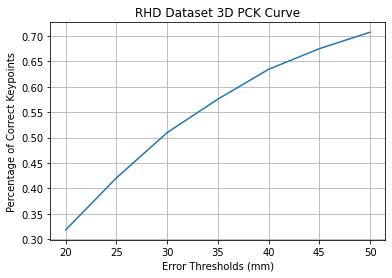

In [2]:
from evaluation import evaluate_model
checkpoint_path = os.path.join('../','checkpoints', "cp-{:04d}.ckpt".format(1151))
model.load_weights(checkpoint_path)
evaluate_model(model, train_dir, "training", download_image, y_train, gcs_path)

In [ ]:
from evaluation import generate_loss_graph
generate_loss_graph(checkpoint_path, model, 
    rhd_eval_dir, download_image, y_test)